## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.linear_model import LinearRegression, Ridge

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional  # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

## Data Preprocessing (General)

In [2]:
# Load data
df = pd.read_csv("../Movie reviews.csv")

# Display the data
df

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay
...,...,...,...,...
522,Pening,0.7,NaN,Malay
523,Berkesan,0.2,NaN,Malay
524,Mengujakan,0.1,NaN,Malay
525,Sederhana and teruk,0.6,NaN,Malay


In [3]:
# Drop all rows where 'Review' is duplicated with the same 'Score'
df = df.drop_duplicates(subset=['Review', 'Score'])

# Drop missing values
df = df.dropna(subset=['Review', 'Score', 'Language'])

# Drop the redundant column
df = df.drop(columns=['Are there ways for you to generate more data? Spliting up sentences, would that help?'])

# Display the data after dropping duplicates
df

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay
...,...,...,...
522,Pening,0.7,Malay
523,Berkesan,0.2,Malay
524,Mengujakan,0.1,Malay
525,Sederhana and teruk,0.6,Malay


In [4]:
# Drop all rows where 'Review' is duplicated but with different 'Score'
dup_reviews = df[df.duplicated('Review', keep=False)]
conflicting = dup_reviews.groupby('Review')['Score'].nunique()
conflicting_reviews = conflicting[conflicting > 1].index

df = df[~df['Review'].isin(conflicting_reviews)]

df = df.reset_index(drop=True)

# Display the data after dropping conflicting reviews
df

,Review,Score,Language
0,"Sayang sekali, pelakon tidak memberikan persem...",0.80,Malay
1,Jalan cerita yang kompleks dan penuh emosi. Su...,0.20,Malay
2,Pembuat filem berjaya memberikan pengalaman ya...,0.05,Malay
3,Adegan aksi yang terlalu banyak dan mengejutka...,0.40,Malay
4,Saya teruja sepanjang filem. Penceritaan yang ...,0.15,Malay
...,...,...,...
388,Pening,0.70,Malay
389,Berkesan,0.20,Malay
390,Mengujakan,0.10,Malay
391,Sederhana and teruk,0.60,Malay


In [5]:
# Change it so that higher scores are more positive reviews
df['Score'] = 1.0 - df['Score']  # Now 0.95 = Very Positive, 0.10 = Very Negative
df['Score'] = df['Score'].round(2)

# Display the data after changing scores
df

,Review,Score,Language
0,"Sayang sekali, pelakon tidak memberikan persem...",0.20,Malay
1,Jalan cerita yang kompleks dan penuh emosi. Su...,0.80,Malay
2,Pembuat filem berjaya memberikan pengalaman ya...,0.95,Malay
3,Adegan aksi yang terlalu banyak dan mengejutka...,0.60,Malay
4,Saya teruja sepanjang filem. Penceritaan yang ...,0.85,Malay
...,...,...,...
388,Pening,0.30,Malay
389,Berkesan,0.80,Malay
390,Mengujakan,0.90,Malay
391,Sederhana and teruk,0.40,Malay


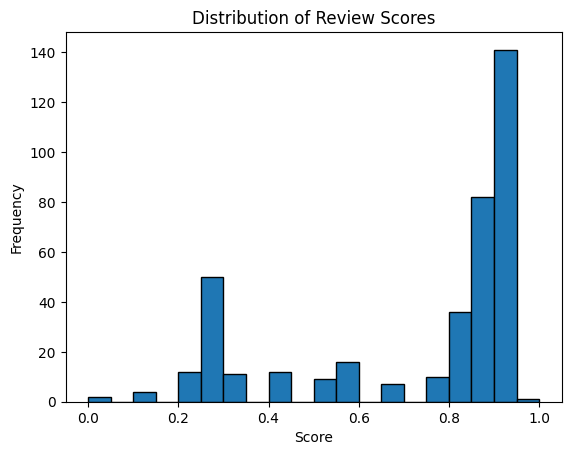

In [6]:
plt.hist(df['Score'], bins=20, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Review Scores')
plt.show()

## Classification Model using Sentiment Analysis

### Data Preparation (Classification Specific)

In [7]:
english_df = df[df['Language'] == 'English']
english_df = english_df.reset_index(drop=True)

In [8]:
# Create labels  
def classify_score(score):  
    if score <= 0.5:  
        return 'Negative'  
    else:  
        return 'Positive'  

english_df['Sentiment'] = english_df['Score'].apply(classify_score)  

# Check distribution  
print(english_df['Sentiment'].value_counts())  

Sentiment
Positive    205
Negative     62
Name: count, dtype: int64


In [9]:
english_df

,Review,Score,Language,Sentiment
0,This movie is amazing! The action is breathtak...,0.92,English,Positive
1,I'm disappointed with the actors' performance....,0.30,English,Negative
2,The storyline is touching and full of emotion....,0.88,English,Positive
3,This movie delivers an outstanding experience....,0.95,English,Positive
4,"Too many action scenes, sometimes unnecessary....",0.60,English,Positive
...,...,...,...,...
262,"Compelling story, outstanding performances",0.88,English,Positive
263,"Intricate plot, unexpected twists",0.90,English,Positive
264,"Underwhelming moments, weak characterizations",0.40,English,Negative
265,"Breathtaking visuals, engaging narrative",0.92,English,Positive


In [10]:
# Get class weights
class_weights = compute_class_weight(
    "balanced", classes=["Negative", "Positive"], y=english_df["Sentiment"]
)
class_weight_dict = dict(zip([0, 1], class_weights))  # Map to label indices

# Display class weights
print("Class weights:", class_weight_dict)

Class weights: {0: 2.153225806451613, 1: 0.651219512195122}


In [11]:
# Vocab size
all_words = " ".join(english_df["Review"]).split()  # Split all reviews into words
word_counts = Counter(all_words)  # Count word frequencies
vocab = sorted(word_counts.keys())  # Sorted list of unique words

# Assign indices to words (0: padding, 1: unknown/OOV)
word_to_idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word_to_idx["<PAD>"] = 0  # Padding token
word_to_idx["<UNK>"] = 1  # Unknown words

print(f"Vocabulary size: {len(vocab)}")
print(f"Number of words: {len(all_words)}")

print(all_words)

Vocabulary size: 1000
Number of words: 4093
['This', 'movie', 'is', 'amazing!', 'The', 'action', 'is', 'breathtaking,', 'and', 'the', 'plot', 'is', 'intriguing.', "I'm", 'disappointed', 'with', 'the', "actors'", 'performance.', 'Not', 'satisfying.', 'The', 'storyline', 'is', 'touching', 'and', 'full', 'of', 'emotion.', 'I', 'love', 'it!', 'This', 'movie', 'delivers', 'an', 'outstanding', 'experience.', 'Truly', 'captivating!', 'Too', 'many', 'action', 'scenes,', 'sometimes', 'unnecessary.', 'Too', 'dramatic.', "I'm", 'thrilled', 'throughout', 'the', 'movie.', 'Engaging', 'storytelling!', 'Avengers:', 'Endgame', 'is', 'disappointing', 'and', 'too', 'cliché.', 'Not', 'enjoyable.', 'I', 'like', 'how', 'this', 'movie', 'combines', 'elements', 'of', 'science', 'fiction.', 'Interesting!', 'This', 'film', 'is', 'truly', 'impressive', 'with', 'deep', 'emotional', 'tones.', 'A', 'cinematic', 'experience', 'that', 'is', 'unforgettable.', "I'm", 'impressed!', 'I', 'feel', 'this', 'movie', "didn't

In [12]:
# Calculate lengths of all reviews (in words)
review_lengths = english_df["Review"].apply(lambda x: len(x.split()))

# Set max_len to cover 90% of reviews (or use median)
max_len = int(np.percentile(review_lengths, 90))  # Adjust percentile as needed
print(f"Optimal max_len: {max_len}")

# Alternative: Use median + buffer
# max_len = int(review_lengths.median() + 10)

Optimal max_len: 44


In [13]:
# Split data into train and test sets
X = english_df["Review"].values
y_labels = english_df["Sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
  X, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

### Train the model

In [14]:
# Tokenize and pad the text data
tokenizer = Tokenizer(num_words=len(vocab) + 2, oov_token="<UNK>")
tokenizer.word_index = word_to_idx  # Use the same word_to_idx mapping

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

In [15]:
# Convert string labels to one-hot encoding
# Map labels to integers: Negative=0, Positive=1
label_map = {"Negative": 0, "Positive": 1}
y_train_int = np.array([label_map[label] for label in y_train])
y_test_int = np.array([label_map[label] for label in y_test])

# One-hot encode
y_train_bin = to_categorical(y_train_int, num_classes=2)
y_test_bin = to_categorical(y_test_int, num_classes=2)

In [16]:
# Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Add ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    'classification_model.h5', monitor='val_loss', save_best_only=True, mode='min'
)

# Add Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.0001)

# Model architecture
base_model = Sequential(
    [
        Embedding(input_dim=len(vocab) + 2, output_dim=32, input_length=max_len),
        Dropout(0.3),
        Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
        Dropout(0.5),
        Dense(2, activation="sigmoid"),
    ]
)

base_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # or even 0.0001
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train with class weights and early stopping
history = base_model.fit(
    X_train_pad,
    y_train_bin,
    validation_data=(X_test_pad, y_test_bin),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

Epoch 1/50
7/7 [==============================] - 3s 74ms/step - loss: 1.7036 - accuracy: 0.4131 - val_loss: 1.6741 - val_accuracy: 0.2778 - lr: 5.0000e-04
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 1.6500 - accuracy: 0.4601 - val_loss: 1.6236 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 1.5993 - accuracy: 0.4178 - val_loss: 1.5703 - val_accuracy: 0.4815 - lr: 5.0000e-04
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 1.5459 - accuracy: 0.5681 - val_loss: 1.5229 - val_accuracy: 0.5185 - lr: 5.0000e-04
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 1.4982 - accuracy: 0.5587 - val_loss: 1.4765 - val_accuracy: 0.6111 - lr: 5.0000e-04
Epoch 6/50
7/7 [==============================] - 0s 12ms/step - loss: 1.4541 - accuracy: 0.5399 - val_loss: 1.4334 - val_accuracy: 0.5556 - lr: 5.0000e-04
Epoch 7/50
7/7 [==============================] - 0s 13ms/step -

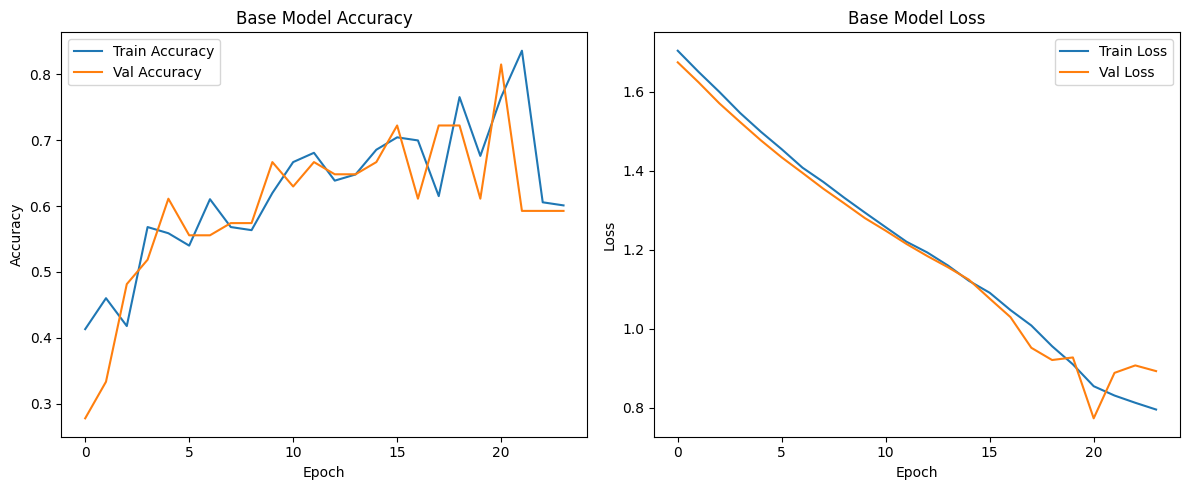

In [17]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Base Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Base Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Predict class probabilities and get predicted labels
y_pred_prob = base_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

    Negative       0.80      0.31      0.44        13
    Positive       0.82      0.98      0.89        41

    accuracy                           0.81        54
   macro avg       0.81      0.64      0.67        54
weighted avg       0.81      0.81      0.78        54



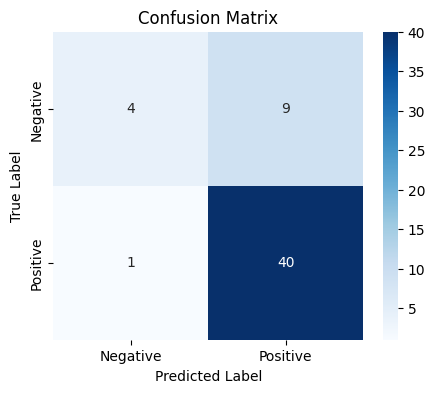

In [19]:
# Plot confusion matrix for classification results
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Base LSTM Regression Model

In [20]:
# Import necessary libraries
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from deep_translator import GoogleTranslator
from tqdm import tqdm

import string  # for punctuation removal
import re  # regex for text cleaning
import logging  # helpful for debugging and info logs

[nltk_data] Downloading package punkt to C:\Users\andre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\andre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\andre/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preparation (Regression Specific)

In [21]:
# Translate non-English reviews to English
translated_reviews = []

# tqdm shows a progress bar
for text in tqdm(df["Review"]):
    try:
        translated = GoogleTranslator(source="auto", target="en").translate(text)
    except Exception as e:
        translated = text  # fallback to original if translation fails
    translated_reviews.append(translated)

# Replace original column or add a new one
df["Translated_Review"] = translated_reviews

100%|██████████| 393/393 [00:43<00:00,  9.04it/s]


In [22]:
# Round the scores to one decimal place
df["Score"] = df["Score"].round(1)
df["Score"] = df["Score"].astype(float)

In [23]:
# Full English stopwords
stop_words = set(stopwords.words("english"))

# Negations to keep
negations = {"not", "no", "nor", "never", "n't"}

# Remove negations from stopwords
stop_words = stop_words - negations

In [24]:
# Define a function to lemmatize text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation & numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]  # optional stopword removal
    lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmatized)

# Apply lemmatization to the translated reviews
df["Cleaned_Review"] = df["Translated_Review"].apply(lemmatize_text)

# Display the data after lemmatization
df

,Review,Score,Language,Translated_Review,Cleaned_Review
0,"Sayang sekali, pelakon tidak memberikan persem...",0.2,Malay,"Unfortunately, the actor didn't give the best ...",unfortunately actor didnt give best performanc...
1,Jalan cerita yang kompleks dan penuh emosi. Su...,0.8,Malay,Complex and emotional storyline. So entertaining!,complex emotional storyline entertaining
2,Pembuat filem berjaya memberikan pengalaman ya...,1.0,Malay,The filmmaker succeeded in providing an unforg...,filmmaker succeeded providing unforgettable ex...
3,Adegan aksi yang terlalu banyak dan mengejutka...,0.6,Malay,Action scenes that are too much and surprising...,action scene much surprising sometimes bit much
4,Saya teruja sepanjang filem. Penceritaan yang ...,0.8,Malay,I'm excited throughout the movie. Interesting ...,im excited throughout movie interesting storyt...
...,...,...,...,...,...
388,Pening,0.3,Malay,Dizzy,dizzy
389,Berkesan,0.8,Malay,Effective,effective
390,Mengujakan,0.9,Malay,Exciting,exciting
391,Sederhana and teruk,0.4,Malay,Moderate and severe,moderate severe


In [25]:
# Prepare X and y for regression
X = df["Cleaned_Review"]
y = df["Score"]

In [26]:
# Get class distribution
class_counts = y.value_counts()

print("Class distribution:")
print(class_counts)

Class distribution:
Score
0.9    215
0.8     46
0.3     36
0.2     30
0.4     23
0.6     16
1.0      9
0.5      9
0.7      7
0.0      2
Name: count, dtype: int64


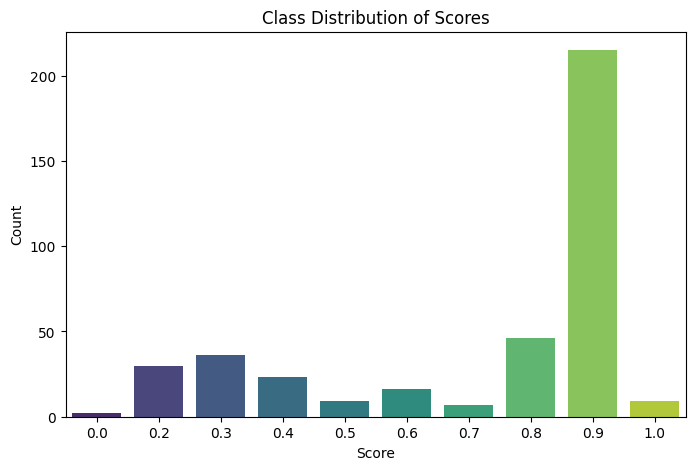

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Class Distribution of Scores")
plt.show()

### Model Training

In [39]:
# MinMax scaling for regression targets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Split train-test (raw texts)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split validation from training (raw texts)
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Create tokenizer on X_train_text onl
tokenizer = Tokenizer(num_words=1002, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

In [40]:
# Set parameters for padding and embedding
max_length = 200
embedding_dim = 32
vocab_size = len(tokenizer.word_index) + 1

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(
    X_train_seq, maxlen=max_length, padding="post", truncating="post"
)
X_val_pad = pad_sequences(
    X_val_seq, maxlen=max_length, padding="post", truncating="post"
)
X_test_pad = pad_sequences(
    X_test_seq, maxlen=max_length, padding="post", truncating="post"
)

In [41]:
# Build base LSTM regression model using padded sequences
lstm_base = Sequential(
    [
        Embedding(
            input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length
        ),
        LSTM(64),
        Dense(1, activation="linear"),
    ]
)

lstm_base.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
lstm_base.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 32)           18528     
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 43,425
Trainable params: 43,425
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Define callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the base LSTM model
history = lstm_base.fit(
    X_train_pad, 
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop]
)

# Evaluate

lstm_pred = lstm_base.predict(X_test_pad).flatten()
print("\n=== LSTM (Base) ===")
print(f"MSE: {mean_squared_error(y_test, lstm_pred):.4f}")
print(f"R²: {r2_score(y_test, lstm_pred):.4f}")

# Save model
lstm_base.save("base_lstm.h5")

Epoch 1/50
9/9 [==============================] - 1s 54ms/step - loss: 0.4082 - mae: 0.5768 - val_loss: 0.1387 - val_mae: 0.3548
Epoch 2/50
9/9 [==============================] - 0s 13ms/step - loss: 0.1066 - mae: 0.2574 - val_loss: 0.0685 - val_mae: 0.2466
Epoch 3/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0957 - mae: 0.2943 - val_loss: 0.0782 - val_mae: 0.2668
Epoch 4/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0765 - mae: 0.2390 - val_loss: 0.0630 - val_mae: 0.1625
Epoch 5/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0741 - mae: 0.2190 - val_loss: 0.0604 - val_mae: 0.2216
Epoch 6/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0708 - mae: 0.2424 - val_loss: 0.0579 - val_mae: 0.2055
Epoch 7/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0708 - mae: 0.2207 - val_loss: 0.0573 - val_mae: 0.1928
Epoch 8/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0708 - mae: 0.2363 - val

In [43]:
def plot_training(history, model_name):
    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss (MSE)")
    plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Training and Validation Loss")
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Val MAE")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.title(f"{model_name} Training and Validation MAE")
    plt.legend()

    plt.show()

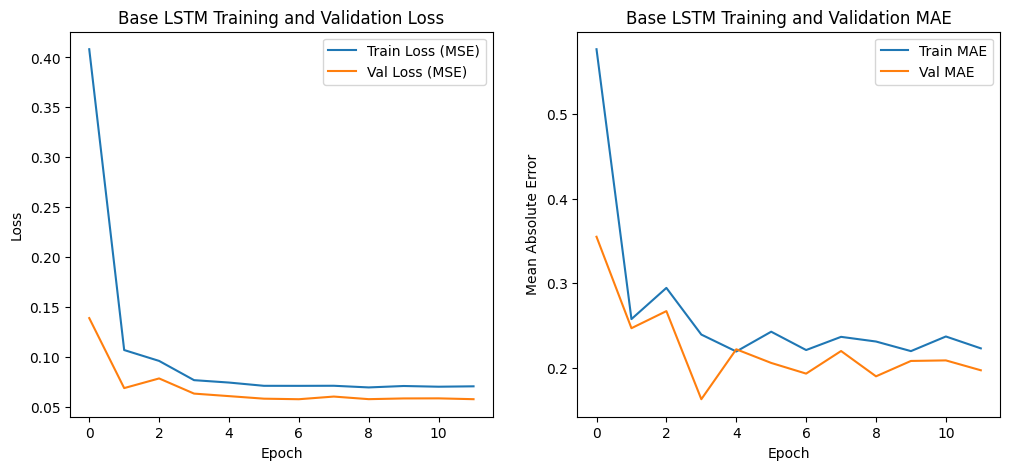

In [44]:
plot_training(history, "Base LSTM")

## Tuned LSTM Regression Model

In [45]:
# Train a tuned LSTM model with more layers and dropout
lstm_tuned = Sequential(
    [
        Embedding(
            input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length
        ),
        # First LSTM layer with return_sequences=True to stack next LSTM
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        # Second LSTM layer
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(1, activation="linear"),  # linear for regression output
    ]
)

lstm_tuned.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
lstm_tuned.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 32)           18528     
                                                                 
 lstm_5 (LSTM)               (None, 200, 128)          82432     
                                                                 
 dropout_4 (Dropout)         (None, 200, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                

In [46]:
# Train the base LSTM model
history = lstm_tuned.fit(
    X_train_pad,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop],
)

# Evaluate
lstm_pred = lstm_tuned.predict(X_test_pad).flatten()
print("\n=== LSTM (Tuned) ===")
print(f"MSE: {mean_squared_error(y_test, lstm_pred):.4f}")
print(f"R²: {r2_score(y_test, lstm_pred):.4f}")

# Save model
lstm_tuned.save("tuned_lstm.h5")

Epoch 1/50
9/9 [==============================] - 2s 76ms/step - loss: 0.3164 - mae: 0.4791 - val_loss: 0.0686 - val_mae: 0.2468
Epoch 2/50
9/9 [==============================] - 0s 24ms/step - loss: 0.0949 - mae: 0.2757 - val_loss: 0.0600 - val_mae: 0.1679
Epoch 3/50
9/9 [==============================] - 0s 21ms/step - loss: 0.0806 - mae: 0.2417 - val_loss: 0.0575 - val_mae: 0.2000
Epoch 4/50
9/9 [==============================] - 0s 22ms/step - loss: 0.0773 - mae: 0.2260 - val_loss: 0.0640 - val_mae: 0.2344
Epoch 5/50
9/9 [==============================] - 0s 20ms/step - loss: 0.0798 - mae: 0.2562 - val_loss: 0.0580 - val_mae: 0.1812
Epoch 6/50
9/9 [==============================] - 0s 22ms/step - loss: 0.0796 - mae: 0.2281 - val_loss: 0.0654 - val_mae: 0.2387
Epoch 7/50
9/9 [==============================] - 0s 22ms/step - loss: 0.0779 - mae: 0.2342 - val_loss: 0.0574 - val_mae: 0.1983
Epoch 8/50
9/9 [==============================] - 0s 21ms/step - loss: 0.0737 - mae: 0.2428 - val

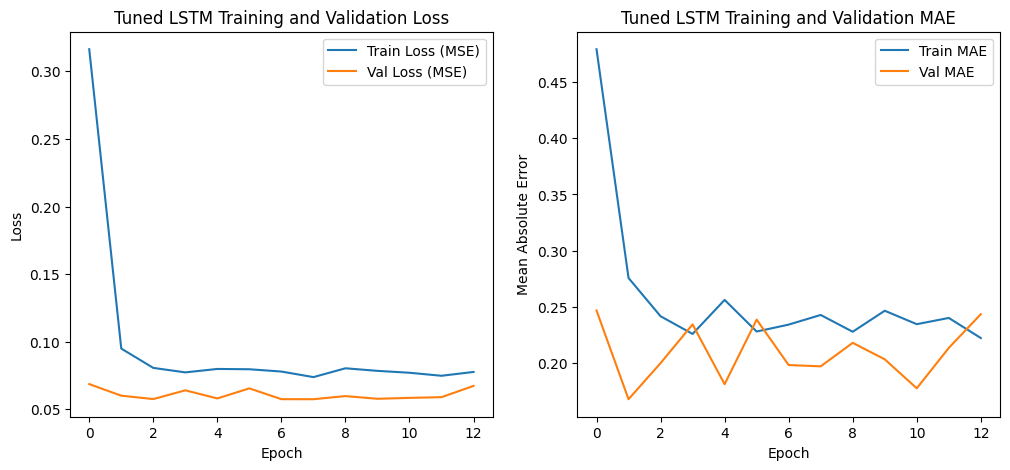

In [47]:
plot_training(history, "Tuned LSTM")